In [124]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.ticker as mtick
from importlib import reload
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from scipy.interpolate import make_interp_spline

# import minimum_detectable_effect_size as mdes

from time import gmtime, strftime
from tqdm import tqdm
from matplotlib import style

pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

warnings.filterwarnings('ignore')

# set the plot style
style.use('fivethirtyeight')
# %matplotlib inline

# sys.path.append('../../ab_testing_utils/') 



# questions for dan
# why "query" instead of normal filtering?
# why the underscore after some variable names?
# why put it all in a class, and how do you determine the ordering of functions / methods / objects in a class?
# what is a @staticmethod?\
# this is all frequentist right? how might we incorporate priors?
# explain the fake data generation
# historical_success_rate_dict is confusing / sketchy?
# which type of t test is this? and what about a prop test?
# can you show examples of all this in action? 

# aggregate, plot, prop, bayes


In [2]:
generate_fake_data = False

# Helpers 

In [3]:
# helper for simple_ab_test 
def calculate_critical_values_for_ci(se: float, 
                                     alpha: float) -> float:
    """
    Helper function to calculate the critical values for confidence interval estimation, given a significance level alpha

    :param se: Standard error. This should come from the simple_ab_test function
    :param alpha: The significance level of the test (i.e. p-value threshold for declaring significance)
    :return: The critical value for the given standard error and desired level of significance
    """

    critical_value = - se * stats.norm.ppf(alpha/2)

    return critical_value

In [4]:
# helper for calc_sample_size
def calc_sigma(baseline_conversion_rate: float, return_square: bool = False) -> float:
    """
    Function to compute the variance of the conversion rate in the underlying population. Since the metric is a conversion type, it is modeled by a Bernoulli random variable. Hence, the
    variance is just p*(1-p), where p in this case is the baseline_conversion_rate (probability of 'success')

    :param baseline_conversion_rate: Expected historical conversion rate prior to experiment
    :param return_square: If True, returns the variance (sigma squared), if False returns the standard deviation (square root of sigma)
    :return: Either the variance or standard deviation of the underlying conversion variable
    """

    sigma_squared = baseline_conversion_rate * (1 - baseline_conversion_rate)

    if return_square:
        return sigma_squared
    else:
        return np.sqrt(sigma_squared)

In [5]:
# helper for calc_sample_size
def calc_delta(baseline_conversion_rate: float, relative_minimum_detectable_effect_size: float) -> float:
    """
    Function to compute delta parameter in experiment design.  It's just the baseline conversion rate (historical) prior to the experiment multiplied by the relative minimum
    detectable effect size

    :param baseline_conversion_rate: Expected historical conversion rate prior to experiment
    :param relative_minimum_detectable_effect_size: The minimum relative percent change in the underlying metric desired to be detected by the experiment
    :return: delta
    """

    delta_ = baseline_conversion_rate * relative_minimum_detectable_effect_size

    return delta_


In [6]:
def calc_standard_error(sample_size: float, sigma: float = None, baseline_conversion_rate: float = None) -> float:
        """
        Function to compute the standard error in conversion rate, given a sample size and a baseline conversion rate (or pre-computed standard deviation)

        :param sample_size: The sample size determined to be needed for the experiment (this is the per-group sample size, so total sample size is twice this value)
        :param sigma: The standard deviation of the underlying conversion variable
        :param baseline_conversion_rate: Expected historical conversion rate prior to experiment
        :return: The standard error of the conversion metric
        """

        assert not all(x is not None for x in [sigma, baseline_conversion_rate]), "Either sigma or baseline_conversion_rate must be specified"

        if sigma is None:
            sigma = calc_sigma(baseline_conversion_rate=baseline_conversion_rate)

        se_ = sigma * np.sqrt(2 / sample_size)

        return se_

In [83]:
# helper for create_mde_table
def calc_sample_size(
                        power: float, 
                        alpha: float, 
                        relative_minimum_detectable_effect_size: float, 
                        baseline_conversion_rate: float) -> float:
    """
    Function to compute the sample size (per group) of a proposed experiment on a conversion metric with baseline_conversion_rate historical conversion rate, desired relative minimum effect size
    of relative_minimum_detectable_effect_size, significance level alpha and power.  Note power here is 1 - beta

    :param power: The desired power of the experiment (1 - beta): the probability of detecting a meaningful difference between variants when there really is one. i.e. rejecting the null
                    hypothesis when there is a true difference of delta = baseline_conversion_rate * relative_minimum_detectable_effect_size
    :param alpha: The significance level of the test (i.e. p-value threshold for declaring significance)
    :param relative_minimum_detectable_effect_size: The minimum relative percent change in the underlying metric desired to be detected by the experiment
    :param baseline_conversion_rate: Expected historical conversion rate prior to experiment
    :return: The sample size required for the experiment. This is the per variant sample size, so the total sample size is twice this number
    """

    sigma_squared = calc_sigma(baseline_conversion_rate=baseline_conversion_rate, return_square=True)
    delta_ = calc_delta(baseline_conversion_rate=baseline_conversion_rate, relative_minimum_detectable_effect_size=relative_minimum_detectable_effect_size)

    z_alpha = stats.norm.ppf(1 - (alpha / 2))
    z_power = stats.norm.ppf(power)

    n = 2 * (sigma_squared * (z_power + z_alpha) ** 2) / (delta_ ** 2)

    return int(np.round(n))

In [78]:
# helper for plot_fprs
def calculate_false_positive_risk(
                                  alpha, 
                                  power, 
                                  historical_success_rate=None):
    """
    Calculates the False Positive Risk (or probability that a statistically significant result is a false positive, i.e. the probability that the null
    hypothesis is true when an experiment was statistically significant)

    :param alpha: The significance level of the test (i.e. p-value threshold for declaring significance)
    :param power: The power of the experiment (1 - beta): the probability of detecting a meaningful difference between variants when there really is one. i.e. rejecting the null
                    hypothesis when there is a true difference of delta = baseline_conversion_rate * relative_minimum_detectable_effect_size
    :param historical_success_rate: The historical rate at which A/B tests result in a true statistically significant outcome. If not provide, a range of values from the literature will
                                    be used (see Kohavi, Deng, Vermeer, 2022 for a summary of known industry values)
    :return: The False Positive Risk: i.e. the probability that the null hypothesis is true when an experiment was observed to be statistically significant
    """

    if historical_success_rate is not None:
        pi = 1 - historical_success_rate
        fpr = alpha * pi / ((alpha * pi) + (power * (1 - pi)))

        return fpr

    else:
        print('Historical success rate not provided.  Will generate False Positive Risk values for different levels of historical success')
        historical_success_rate_dict = {'Microsoft': 0.333, 'Bing': 0.15, 'Google Ads or Netflix': 0.1, 'Airbnb': 0.08}
        possible_fprs = {}
        for company_name, success_rate in historical_success_rate_dict.items():
            label_ = 'If our success rate was that of {0}'.format(company_name)
            pi_ = 1 - success_rate
            fpr_ = alpha * pi_ / ((alpha * pi_) + (power * (1 - pi_)))
            possible_fprs[label_] = (fpr_, success_rate)

        self.plot_fprs(fpr_dict=possible_fprs, alpha=alpha, power=power)

In [9]:
# plot helper 2
def format_y_axis(x: float, pos) -> str:
    """
    Helper function to format the y-axis of the MDE vs runtime plot.

    :param x: A number used as a tick on a matplotlib plot that you want to format
    :param pos: This is a position indicator used internally by matplotlib to figure out where to plot the tick. You should never have to interact with it directly.
    :return: The formatted tick mark
    """

    return f"{int(x):,}"

In [79]:
# plot helper 3 
def plot_mde_marker(df: pd.DataFrame, weeks: int, days: int, ax):
    """
    Function to format the minimum detectable effect size plot.  This will add horizontal lines to indicate the required number of weeks, as well as annotate the plot to
    indicate the minimum detectable effect size along with the range of effect sizes that will not be detectable by the experiment at the desired level of significance and
    power.

    :param df: A DataFrame with experimental runtime and minimum detectable effect sizes.  This should be the output of the create_mde_table method.
    :param weeks: The number of weeks for one particular instance of the experiment, at a given level of significance, power, and effect size
    :param days: The number of days for one particular instance of the experiment, at a given level of significance, power, and effect size
    :param ax: The matplotlib ax object for the overall plot. Generated by the make_mde_plot function
    :return: Nothing. Just adds formatting to the existing plot object
    """

    ax.axhline(y=days, linestyle='--', xmax=(df[df['days'] <= days]['mde'].min() - ax.get_xlim()[0]) / ax.get_xlim()[1] - 0.005)

    if weeks > 1:
        week_text = 'weeks'
    else:
        week_text = 'week'

    ax.text(ax.get_xlim()[0], days + 1, f"{weeks} {week_text}", horizontalalignment='left')

    mde_text = "MDE = {0}%:\nConversion rates between {1}% and {2}% will not be distinguishable from baseline".format(np.round(df[df['weeks'] == weeks]['mde'].min() * 100, 3),
                                                                                                                        np.round(df[df['weeks'] == weeks]['new_conversion_rate_lower_bound'].min() * 100, 3),
                                                                                                                        np.round(df[df['weeks'] == weeks]['new_conversion_rate_upper_bound'].min() * 100, 3))

    ax.text(df[df['weeks'] <= weeks]['mde'].min() * 1.05, days - 0.5, mde_text, horizontalalignment='left')

In [11]:
# random helper
def round_and_convert_to_int_columns(df_: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """
    Function to format input column from DataFrame df_.  This will round numerical values and convert to integer. For experiment runtime columns, the values will be rounded up
    to the nearest integer as runtime estimates should be conservative. Caution: This will modify the input DataFrame inplace.

    :param df_: DataFrame with the column you want to format
    :param col_name: The name of the column to format
    :return: The original DataFrame with the input column now formatted.
    """

    if col_name in ['monthly_additional_conversions_upper', 'monthly_additional_conversions_lower']:
        df_[col_name] = np.round(df_[col_name])
        df_[col_name] = df_[col_name].astype(int)
    else:
        df_[col_name] = np.ceil(df_[col_name])
        df_[col_name] = df_[col_name].astype(int)

    return df_

# Key Outputs

In [77]:
def calc_experiment_power(
                          sample_size: float, 
                          alpha: float, 
                          relative_minimum_detectable_effect_size: float, 
                          baseline_conversion_rate: float, 
                          p_value: float = None) -> float:
    """
    Function to compute power of an experiment.  This should be used to calculate power of a test based on desired inputs. Note that this formulation ignores the
    possibility of type 3 error: i.e. rejection based on the wrong tail.  Can we correct for this in future versions?

    :param sample_size: The number of samples desired per variant (so this is the total experiment population / 2)
    :param alpha: The significance level of the test (i.e. p-value threshold for declaring significance)
    :param relative_minimum_detectable_effect_size: The minimum relative percent change in the underlying metric desired to be detected by the experiment
    :param baseline_conversion_rate: Expected historical conversion rate prior to experiment
    :param p_value: Observed p-value from concluded experiment. Include this only if you want to compute post-hoc power. WARNING: THIS IS AN UNRELIABLE MEASURE OF YOUR EXPERIMENTS RESULTS (See
    Kohavi, Deng, Vermeer, 2022).
    :return: The power of the test
    """
    # TODO: Add p_value functionality

    delta_ = calc_delta(baseline_conversion_rate=baseline_conversion_rate, relative_minimum_detectable_effect_size=relative_minimum_detectable_effect_size)
    se_ = calc_standard_error(sample_size=sample_size, baseline_conversion_rate=baseline_conversion_rate)

    z_value = stats.norm.ppf(1 - (alpha / 2))
    v_ = (delta_ / se_) - z_value

    power_ = stats.norm.cdf(x=v_)

    return power_

In [80]:
def create_mde_table(
#                     self, 
                     monthly_num_obs: int, 
                     baseline_conversion_rate: float, 
                     n_variants: int = 2, 
                     alpha: float = 0.05, 
                     power: float = 0.8) -> pd.DataFrame:
    """
    Function to generate a minimum detectable effect size table.  The idea here is to produce a DataFrame which matches minimum detectable effect sizes with required sample
    sizes, at the desired level of confidence and power.  Coupled with the expected monthly number of observations, this will provide an estimate for experiment runtime vs the
    size of the effect the experiment can detect.  One assumption is that the expected daily number of observations is the monthly value supplied divided by 30. It's
    important to make sure that the monthly expected number of observations is accurate, or less the experiment runtimes could be unrealistic. Also note, ths simplified
    approach assumes that the standard deviation between control and variants is the same. Furthermore, if you use more than 2 variants, note that this can only recommend
    designs which split the population evenly amongst all variants.  For example, if you request 3 variants, the design assumes the population will be split as 1/3 in control
    1/3 in variant A and the remaining 1/3 in variant B.

    :param monthly_num_obs: The expected number of observations (i.e. merchants, view, whatever the experimental unit is) seen in a 30 day period
    :param baseline_conversion_rate: Expected historical conversion rate prior to experiment
    :param n_variants: The number of variants you want to use in your test.  Usually this is two (control and exposure), but you can add any integer number here if you really
                        want to.  Be very careful when proposing multi-variant experiments! Be sure to consult with a data scientist first. Multi-variant experiments can be
                        tricky, and are prone to multiple hypothesis testing bias.
    :param alpha: The significance level of the test (i.e. p-value threshold for declaring significance)
    :param power: The desired power of the experiment (1 - beta): the probability of detecting a meaningful difference between variants when there really is one. i.e. rejecting the null
                    hypothesis when there is a true difference of delta = baseline_conversion_rate * relative_minimum_detectable_effect_size
    :return: A DataFrame with a range of different experiment runtimes, the required sample size and the magnitude of the effect that can be measured, given the supplied level
                of confidence and power
    """

    mde_range = np.arange(0.001, 2.001, 0.001)

    sample_sizes = [calc_sample_size(power=power,
                                          alpha=alpha,
                                          relative_minimum_detectable_effect_size=mde,
                                          baseline_conversion_rate=baseline_conversion_rate) * n_variants for mde in mde_range
                    ]

    new_conversion_rates_upper = [baseline_conversion_rate + calc_delta(baseline_conversion_rate=baseline_conversion_rate,
                                                                                relative_minimum_detectable_effect_size=mde) for mde in mde_range
                                    ]

    new_conversion_rates_lower = [baseline_conversion_rate - calc_delta(baseline_conversion_rate=baseline_conversion_rate,
                                                                                relative_minimum_detectable_effect_size=mde) for mde in mde_range
                                    ]

    df_ = pd.DataFrame()
    df_['mde'] = mde_range
    df_['new_conversion_rate_upper_bound'] = new_conversion_rates_upper
    df_['new_conversion_rate_lower_bound'] = new_conversion_rates_lower
    df_['total_sample_size'] = sample_sizes
    df_['sample_size_per_variant'] = np.array(sample_sizes) / n_variants
    df_['days'] = df_['total_sample_size'] / (monthly_num_obs / 30)
    df_['weeks'] = df_['days'] / 7
    df_['weeks_non_rounded'] = df_['days'] / 7
    df_['fraction_of_expected_monthly_sample'] = df_['total_sample_size'] / monthly_num_obs
    df_['monthly_additional_conversions_upper'] = (df_['new_conversion_rate_upper_bound'] * monthly_num_obs) - (baseline_conversion_rate * monthly_num_obs)
    df_['monthly_additional_conversions_lower'] = (df_['new_conversion_rate_lower_bound'] * monthly_num_obs) - (baseline_conversion_rate * monthly_num_obs)

    for col_ in ['total_sample_size', 'sample_size_per_variant', 'days', 'weeks', 'monthly_additional_conversions_upper', 'monthly_additional_conversions_lower']:
        df_ = round_and_convert_to_int_columns(df_=df_, col_name=col_)

    return df_

In [14]:
def simple_ab_test(self, df: pd.DataFrame, group_column_name: str, treatment_name: str, outcome_column: str, alpha: float, null_hypothesis: float) -> pd.DataFrame:
    """
    Simple function to compare the outcomes in an A/B experiment (i.e. 2 variants).  This just compares the means of the control and treatment groups, modeled as the difference
    between two normal distributions.  This will calculate the p-value, as well as compute the confidence interval at the desired significance level alpha.

    :param df: DataFrame which contains the experiment results. There should be a column with the actual outcome variable, and a column indicating which group the observation
                is from.
    :param group_column_name: Name of the column which contains the group assignments
    :param treatment_name: The name of the treatment group in the group_column_name column. This is a two variant test, so it's assumed that anything not in this group is in
                            the control
    :param outcome_column: The name of the column containing the measured outcome variable
    :param alpha: The significance level of the test
    :param null_hypothesis: The null difference we are testing against. Usually this is zero; i.e. the null hypothesis is that the difference in means between control and
                            treatment groups is zero. This doesn't have to be the case, and you can specify a different value of this difference if you want.
    :return: A DataFrame with the A/B test results. Namely, the observed means in both control and treatment (along with confidence intervals), as well as the difference in
    means, its confidence interval, the measured Z statistic, and the p-value.
    """

    df_stats = df.groupby(group_column_name).describe()

    # group means
    mu_treatment = df_stats[df_stats.index == treatment_name][(outcome_column, 'mean')]
    mu_control = df_stats[df_stats.index != treatment_name][(outcome_column, 'mean')]

    # group standard deviations≈
    std_treatment = df_stats[df_stats.index == treatment_name][(outcome_column, 'std')]
    std_control = df_stats[df_stats.index != treatment_name][(outcome_column, 'std')]

    # group sample sizes
    count_treatment = df_stats[df_stats.index == treatment_name][(outcome_column, 'count')]
    count_control = df_stats[df_stats.index != treatment_name][(outcome_column, 'count')]

    # Compute standard errors
    se_treatment = std_treatment[0] / np.sqrt(count_treatment[0])
    se_control = std_control[0] / np.sqrt(count_control[0])

    # Compute effect size:
    diff_ = mu_treatment[0] - mu_control[0]

    # Compute standard error for difference in treatment and control distributions
    se_diff_ = np.sqrt(((std_treatment[0]**2) / count_treatment[0]) + ((std_control[0]**2) / count_control[0]))

    z_statistic = (diff_ - null_hypothesis) / se_diff_
    p_value = stats.norm.cdf(z_statistic)

    critical_value_treatment = - se_treatment * stats.norm.ppf(alpha/2)
    critical_value_control = - se_control * stats.norm.ppf(alpha/2)
    critical_value_diff = - se_diff_ * stats.norm.ppf(alpha/2)

    df_results = pd.DataFrame()
    
    df_results['treatment_mean'] = mu_treatment[0]
    df_results['treatment_confidence_interval_{0}_percent_lower'.format(np.round((1 - alpha)*100), 2)] = mu_treatment - critical_value_treatment
    df_results['treatment__confidence_interval_{0}_percent_upper'.format(np.round((1 - alpha)*100), 2)] = mu_treatment + critical_value_treatment

    df_results['control_mean'] = mu_control[0]
    df_results['control_confidence_interval_{0}_percent_lower'.format(np.round((1 - alpha)*100), 2)] = mu_control - critical_value_control
    df_results['control_confidence_interval_{0}_percent_upper'.format(np.round((1 - alpha)*100), 2)] = mu_control + critical_value_control

    df_results['treatment_minus_control_mean'] = diff_
    df_results['control_confidence_interval_{0}_percent_lower'.format(np.round((1 - alpha)*100), 2)] = diff_ - critical_value_diff
    df_results['control_confidence_interval_{0}_percent_upper'.format(np.round((1 - alpha)*100), 2)] = diff_ + critical_value_diff        

    df_results['count_control'] = count_control[0]
    df_results['count_treatment'] = count_treatment[0]

    df_results['std_control'] = std_control[0]
    df_results['std_treatment'] = std_treatment[0]

    df_results['z_statistic'] = z_statistic
    df_results['p_value'] = p_value
    df_results['pct_change'] = df_results['treatment_minus_control_mean'] / df_results['control_mean']

    return df_results

In [54]:
def simple_ab_test_aggregate(self, mu_treatment: float, 
                                   mu_control: float,
                                   std_treatment: float,
                                   std_control: float,
                                   count_treatment: float,
                                   count_control: float,
                                   alpha: float, 
                                   null_hypothesis: float) -> pd.DataFrame:
    
    # Compute standard errors
    se_treatment = std_treatment / np.sqrt(count_treatment)
    se_control = std_control / np.sqrt(count_control)    

    # Compute effect size:
    diff_ = mu_treatment - mu_control

    # Compute standard error for difference in treatment and control distributions
    se_diff_ = np.sqrt(((std_treatment**2) / count_treatment) + ((std_control**2) / count_control))

    z_statistic = (diff_ - null_hypothesis) / se_diff_
    p_value = stats.norm.cdf(z_statistic)

    critical_value_treatment = - se_treatment * stats.norm.ppf(alpha/2)
    critical_value_control = - se_control * stats.norm.ppf(alpha/2)
    critical_value_diff = - se_diff_ * stats.norm.ppf(alpha/2)

#     df_results = pd.DataFrame()
    df_results = pd.DataFrame({'placeholder_col': [5]}) # weird hack i have to do for now with the placeholder
    
    df_results['treatment_mean'] = mu_treatment
    df_results['treatment_confidence_interval_{0}_percent_lower'.format(np.round((1 - alpha)*100), 2)] = mu_treatment - critical_value_treatment
    df_results['treatment__confidence_interval_{0}_percent_upper'.format(np.round((1 - alpha)*100), 2)] = mu_treatment + critical_value_treatment

    df_results['control_mean'] = mu_control
    df_results['control_confidence_interval_{0}_percent_lower'.format(np.round((1 - alpha)*100), 2)] = mu_control - critical_value_control
    df_results['control_confidence_interval_{0}_percent_upper'.format(np.round((1 - alpha)*100), 2)] = mu_control + critical_value_control

    df_results['treatment_minus_control_mean'] = diff_
    df_results['control_confidence_interval_{0}_percent_lower'.format(np.round((1 - alpha)*100), 2)] = diff_ - critical_value_diff
    df_results['control_confidence_interval_{0}_percent_upper'.format(np.round((1 - alpha)*100), 2)] = diff_ + critical_value_diff        

    df_results['count_control'] = count_control
    df_results['count_treatment'] = count_treatment

    df_results['std_control'] = count_control
    df_results['std_treatment'] = count_treatment

    df_results['z_statistic'] = z_statistic
    df_results['p_value'] = p_value
    df_results['pct_change'] = df_results['treatment_minus_control_mean'] / df_results['control_mean']

    return df_results

# Plots

In [16]:
# false positive risks
def plot_fprs(fpr_dict, alpha, power):
    """
    Function to plot False Positive Risks

    :param fpr_dict: Dictionary output by the calculate_false_positive_risk function if no historical_success_rate is passed
    :param alpha: The significance level of the test (i.e. p-value threshold for declaring significance)
    :param power: The power of the experiment (1 - beta): the probability of detecting a meaningful difference between variants when there really is one. i.e. rejecting the null
                  hypothesis when there is a true difference of delta = baseline_conversion_rate * relative_minimum_detectable_effect_size
    :return: Nothing, just makes the plot.
    """

    x = np.linspace(0.05, 0.5, 100)

    plt.figure(figsize=(20, 10))
    plt.plot(x, calculate_false_positive_risk(alpha=alpha, power=power, historical_success_rate=x), color='blue', linewidth=3)
    markers_ = ['go', 'rD', 'mH', 'kv']
    i = 0
    for label_, success_rate in fpr_dict.items():
        plt.plot(success_rate[1], success_rate[0], markers_[i], markersize=12, label=label_)
        i += 1

    plt.title("False Positive Risk (FPR) as a function of experiment success rate at alpha={0}, beta={1}".format(alpha, 1 - power), fontsize=18)
    plt.xlabel('Historical experiment success rate', fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel("False Positive Risk", fontsize=18)
    plt.yticks(fontsize=14)
    plt.legend()
    plt.tight_layout()
    # plt.savefig("FPR.png", facecolor='w')

In [90]:
def make_mde_plot(df_: pd.DataFrame, min_weeks: int, max_weeks: int, save_path: str = None, output_filename: str = None, conservative_runtime: bool = False, figsize: tuple = (12, 8)):
    """
    Function to make a plot of the minimum detectable effect sizes by experiment run time in weeks.  This is plot the number of required weeks (conservatively) against the minimum (conservatively)
    effect size detectable at the required power and significance levels

    :param df_: A DataFrame with experimental runtime and minimum detectable effect sizes.  This should be the output of the create_mde_table method.
    :param min_weeks: The minimum number of weeks you would consider running an experiment for.  It is important to take business cycles into consideration here. As a general rule, 2 weeks is a
                      bare minimum to run an A/B test
    :param max_weeks: The maximum number of weeks you would consider running an experiment for. This is a business decision; ultimately running an experiment is expensive and if the run time
                      is longer than the cost justifies, reconsider running an experiment in the first place
    :param save_path: Path to save the plot to. If None, the file will be saved to the current working directory.
    :param output_filename: Optional str name for the file where the plot will be saved. If None, the file will be called experiment_runtime_vs_mde_CURRENT_TIME.png
    :param conservative_runtime: Boolean. If True, will select the max of the minimum detectable effect size. This means it will pick the MDE for the shortest number of days \
                                 per number of weeks. For example, if 4 weeks, will select the max MDE associated with a 22 days experiment runtime. Use this if your underlying
                                 population and baseline conversion rates are estimated from high variable data.
    :param figsize: Tuple: sets the figsize argument in matplotlib.subplot()
    :return: Nothing. Generates a plot of the minimum detectable effect sizes vs the number of required weeks at the desired level of significance and power
    """

    current_time = strftime('%Y-%m-%d_%H%M%S', gmtime())

    fig, ax = plt.subplots(figsize=figsize)
    df_temp = df_.copy()

    # This should remove the necessity of calculating all these mins below...
    if conservative_runtime:
        df_temp = df_temp[['mde', 'days', 'weeks', 'new_conversion_rate_upper_bound', 'new_conversion_rate_lower_bound']].loc[(df_temp.groupby('weeks')['weeks_non_rounded'].idxmin())]
    else:
        # Be careful with this setting. This could select experimental run times which are borderline almost exactly equal to the expected monthly observations.
        # If your expected observation number is coming from high variability data, this could result in an unachievable sample size in the suggested number of weeks.
        df_temp = df_temp[['mde', 'days', 'weeks', 'new_conversion_rate_upper_bound', 'new_conversion_rate_lower_bound']].loc[(df_temp.groupby('weeks')['weeks_non_rounded'].idxmax())]

    ax.plot("mde",
            "days",
            data=df_temp.loc[(df_temp['weeks'] >= min_weeks) & (df_temp['weeks'] <= max_weeks)],
            linewidth=2,
            solid_capstyle="round",
            linestyle='--',
            marker='o',
            color='b'
            )

    ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_y_axis))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    ax.set_xlabel('Minimum detectable effect size')
    ax.set_ylabel('')

    # Set the x-axis limit
    x_limit = df_temp[df_temp["weeks"] <= min_weeks]["mde"].min() * 1.2
    x_min = df_temp[df_temp['weeks'] == max_weeks]['mde'].min()
    x_min = x_min - 0.1 * x_min
    ax.set_xlim([x_min, x_limit])

    for weeks in range(min_weeks, max_weeks + 1):
        days_ = df_temp.query('weeks == {0}'.format(weeks))['days'].min()
        plot_mde_marker(df=df_temp, weeks=weeks, days=days_, ax=ax)

    ax.set_title('Experiment run times by minimum detectable effect size', fontsize=20)

    # We don't need the y-axis here
    ax.axes.get_yaxis().set_visible(False)

    ax.yaxis.grid(True)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    if save_path is None:
        save_path = os.getcwd()

    if output_filename is None:
        file_name = 'experiment_runtime_vs_mde_{0}.png'.format(current_time)
    else:
        if not output_filename.endswith('.png'):
            file_name = output_filename + '.png'
        else:
            file_name = output_filename

    save_path = os.path.join(save_path, file_name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Examples

### Kaggle House Price Using Above Functions

In [92]:
from pydataset import data
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np

In [94]:
# from kaggle
api = KaggleApi()
api.authenticate()
api.competitions_list(category='gettingStarted')
# or ‘all’, ‘featured’, ‘research’, ‘recruitment’, ‘gettingStarted’, ‘masters’, ‘playground’

# grabbing data
api.competition_list_files('house-prices-advanced-regression-techniques')
api.competition_download_files('house-prices-advanced-regression-techniques')
from zipfile import ZipFile
zf = ZipFile('house-prices-advanced-regression-techniques.zip')
zf.extractall('data')
zf.close()

! cd data && ls

data_description.txt  test.csv
sample_submission.csv train.csv


In [95]:
# defining data variables
sample_submission = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

In [96]:
# plotting power calc estimates for theoretical run times

ab_test_sample = train[train.YrSold.isin([2008,2009])]
ab_test_sample['YrSold'] = ab_test_sample['YrSold'].astype(str)
ab_test_sample = ab_test_sample[['YrSold', 'SalePrice']]
# ab_test_sample

df_mde = create_mde_table(monthly_num_obs=10000, baseline_conversion_rate=0.1, alpha=0.05, power=0.8)
# df_mde

make_mde_plot(df_ = df_mde,
              min_weeks = 1, 
              max_weeks =  12, 
              save_path = None, 
              output_filename = None, 
              conservative_runtime = False, 
              figsize = (12, 8))


        treatment_mean  treatment_confidence_interval_95.0_percent_lower  \
YrSold                                                                     
2009               NaN                                     170809.730912   

        treatment__confidence_interval_95.0_percent_upper   control_mean  \
YrSold                                                                     
2009                                        188054.476189  177360.838816   

        control_confidence_interval_95.0_percent_lower  \
YrSold                                                   
2009                                       -9581.92001   

        control_confidence_interval_95.0_percent_upper  \
YrSold                                                   
2009                                      13724.449479   

        treatment_minus_control_mean  count_control  count_treatment  \
YrSold                                                                 
2009                     2071.264735          30

In [97]:

# running ab test

ab_test_sample = train[train.YrSold.isin([2008,2009])]
ab_test_sample['YrSold'] = ab_test_sample['YrSold'].astype(str)
ab_test_sample = ab_test_sample[['YrSold', 'SalePrice']]
# ab_test_sample

experiment_results = simple_ab_test(self = False, 
                                    df=ab_test_sample, 
                                    group_column_name = 'YrSold', 
                                    treatment_name = '2009', 
                                    outcome_column = 'SalePrice', 
                                    alpha = 0.05, 
                                    null_hypothesis = 0.0)
print(experiment_results)
print('---------------------------------------')
print("""The treatment is {0} percent different from the control. The p-value is {1}. The control group had a sample size of {2}
and the treatment group had a sample size of {3}. The control mean was {4} vs a treatment mean of {5}. 
""".format(experiment_results['pct_change'][0],
           experiment_results['p_value'][0],
           experiment_results['count_control'][0],
           experiment_results['count_treatment'][0],
           experiment_results['control_mean'][0],
           experiment_results['treatment_mean'][0]))
# experiment_results['treatment_minus_control_mean'] / experiment_results['control_mean'][0] #pct lift
# experiment_results['p_value'][0]
# experiment_results['control_mean'][0]
# experiment_results['2009_mean'][0]


   placeholder_col  treatment_mean  \
0                5          175289   

   treatment_confidence_interval_95.0_percent_lower  \
0                                     166666.652661   

   treatment__confidence_interval_95.0_percent_upper  control_mean  \
0                                      183911.347339        177360   

   control_confidence_interval_95.0_percent_lower  \
0                                   -13724.119846   

   control_confidence_interval_95.0_percent_upper  \
0                                     9582.119846   

   treatment_minus_control_mean  count_control  count_treatment  std_control  \
0                         -2071          304.0            338.0        304.0   

   std_treatment  z_statistic   p_value  pct_change  
0          338.0    -0.348326  0.363798   -0.011677  
---------------------------------------
The treatment is 0.011678252924015885 percent different from the control. The p-value is 0.6362183297431623. The control group had a sample size of 

In [ ]:
# grabbing summary stats from above as if we already had them aggregated and running ab test

experiment_results_agg = simple_ab_test_aggregate(self = False,  mu_treatment = 175289, 
                                        mu_control = 177360,
                                        std_treatment = 80879,
                                        std_control = 69735,
                                        count_treatment = 338.0,
                                        count_control = 304.0,
                                        alpha = 0.05, 
                                        null_hypothesis = 0.0)

# experiment_results_agg

print(experiment_results_agg)
print('---------------------------------------')
print("""The treatment is {0} percent different from the control. The p-value is {1}. The control group had a sample size of {2}
and the treatment group had a sample size of {3}. The control mean was {4} vs a treatment mean of {5}. 
""".format(experiment_results['pct_change'][0],
           experiment_results['p_value'][0],
           experiment_results['count_control'][0],
           experiment_results['count_treatment'][0],
           experiment_results['control_mean'][0],
           experiment_results['treatment_mean'][0]))

In [130]:
# same thing but using dan's module

import conversion_rate_utils
# reload(conversion_rate_utils)

ab_test_sample = train[train.YrSold.isin([2008,2009])]
ab_test_sample['YrSold'] = ab_test_sample['YrSold'].astype(str)
ab_test_sample = ab_test_sample[['YrSold', 'SalePrice']]
# ab_test_sample


test_experiment = conversion_rate_utils.ConversionExperiment()

experiment_results = test_experiment.simple_ab_test(
                                                    df=ab_test_sample, 
                                                    group_column_name = 'YrSold', 
                                                    treatment_name = '2009', 
                                                    outcome_column = 'SalePrice', 
                                                    alpha = 0.05, 
                                                    null_hypothesis = 0.0)

print(experiment_results)
print('---------------------------------------')
print("""The treatment is {0} percent different from the control. The p-value is {1}. The control group had a sample size of {2}
and the treatment group had a sample size of {3}. The control mean was {4} vs a treatment mean of {5}. 
""".format(
           'blah', # experiment_results['pct_change'][0],
           experiment_results['p_value'][0],
           'blah', # experiment_results['count_control'][0],
           'blah', # experiment_results['count_treatment'][0],
           experiment_results['control_mean'][0],
           experiment_results['treatment_mean'][0]))
# experiment_results['treatment_minus_control_mean'] / experiment_results['control_mean'][0] #pct lift
# experiment_results['p_value'][0]
# experiment_results['control_mean'][0]
# experiment_results['2009_mean'][0]


        treatment_mean  treatment_confidence_interval_95.0_percent_lower  \
YrSold                                                                     
2009               NaN                                     170809.730912   

        treatment__confidence_interval_95.0_percent_upper   control_mean  \
YrSold                                                                     
2009                                        188054.476189  177360.838816   

        control_confidence_interval_95.0_percent_lower  \
YrSold                                                   
2009                                       -9581.92001   

        control_confidence_interval_95.0_percent_upper  \
YrSold                                                   
2009                                      13724.449479   

        treatment_minus_control_mean  z_statistic   p_value  
YrSold                                                       
2009                     2071.264735     0.348369  0.636218  
------

In [ ]:
df_mde = test_experiment.create_mde_table(monthly_num_obs=monthly_num_observations, baseline_conversion_rate=baseline_conversion_rate, alpha=alpha, power=power)
df_mde.head()

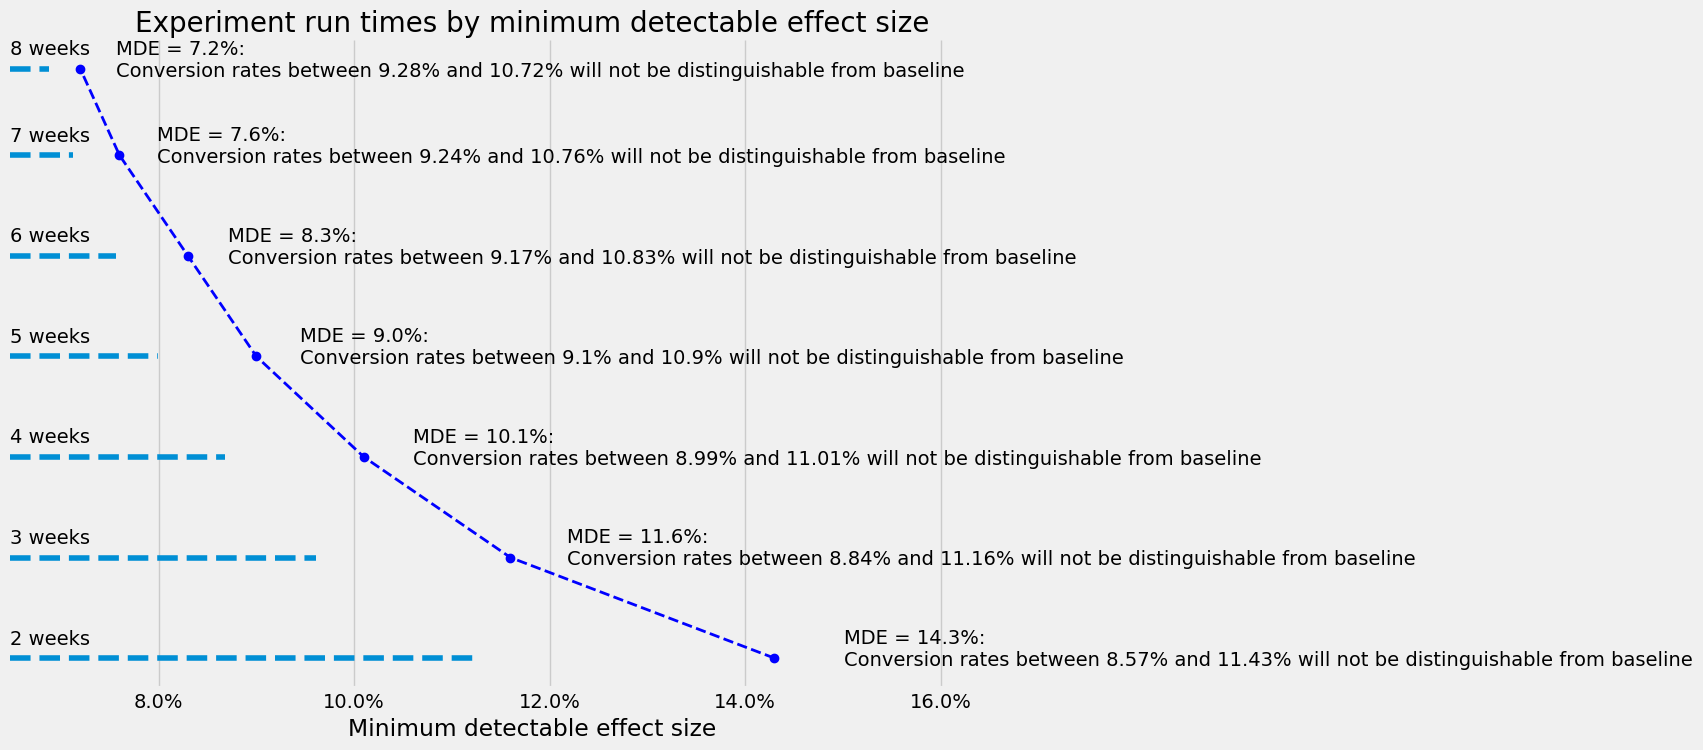

In [125]:
test_experiment.make_mde_plot(df_=df_mde, min_weeks=2, max_weeks=8)

In [101]:
# same things as above but using dan's module and fake aggregate data
import conversion_rate_utils
# reload(conversion_rate_utils)

In [102]:
test_experiment = conversion_rate_utils.ConversionExperiment()

monthly_num_observations = 30000
baseline_conversion_rate = 0.1
n_variants = 2
alpha = 0.05
power = 0.8

In [106]:
df_mde = test_experiment.create_mde_table(monthly_num_obs=monthly_num_observations, baseline_conversion_rate=baseline_conversion_rate, alpha=alpha, power=power)
df_mde.head()

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,weeks_non_rounded,fraction_of_expected_monthly_sample,monthly_additional_conversions_upper,monthly_additional_conversions_lower
0,0.001,0.1001,0.0999,282559670,141279835,282560,40366,40365.667143,9418.655667,3,-3
1,0.002,0.1002,0.0998,70639918,35319959,70640,10092,10091.416857,2354.663933,6,-6
2,0.003,0.1003,0.0997,31395518,15697759,31396,4486,4485.074000,1046.517267,9,-9
3,0.004,0.1004,0.0996,17659980,8829990,17660,2523,2522.854286,588.666000,12,-12
4,0.005,0.1005,0.0995,11302386,5651193,11303,1615,1614.626571,376.746200,15,-15


In [108]:
df_mde.query('mde == 0.05')

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,weeks_non_rounded,fraction_of_expected_monthly_sample,monthly_additional_conversions_upper,monthly_additional_conversions_lower
49,0.05,0.105,0.095,113024,56512,114,17,16.146286,3.767467,150,-150


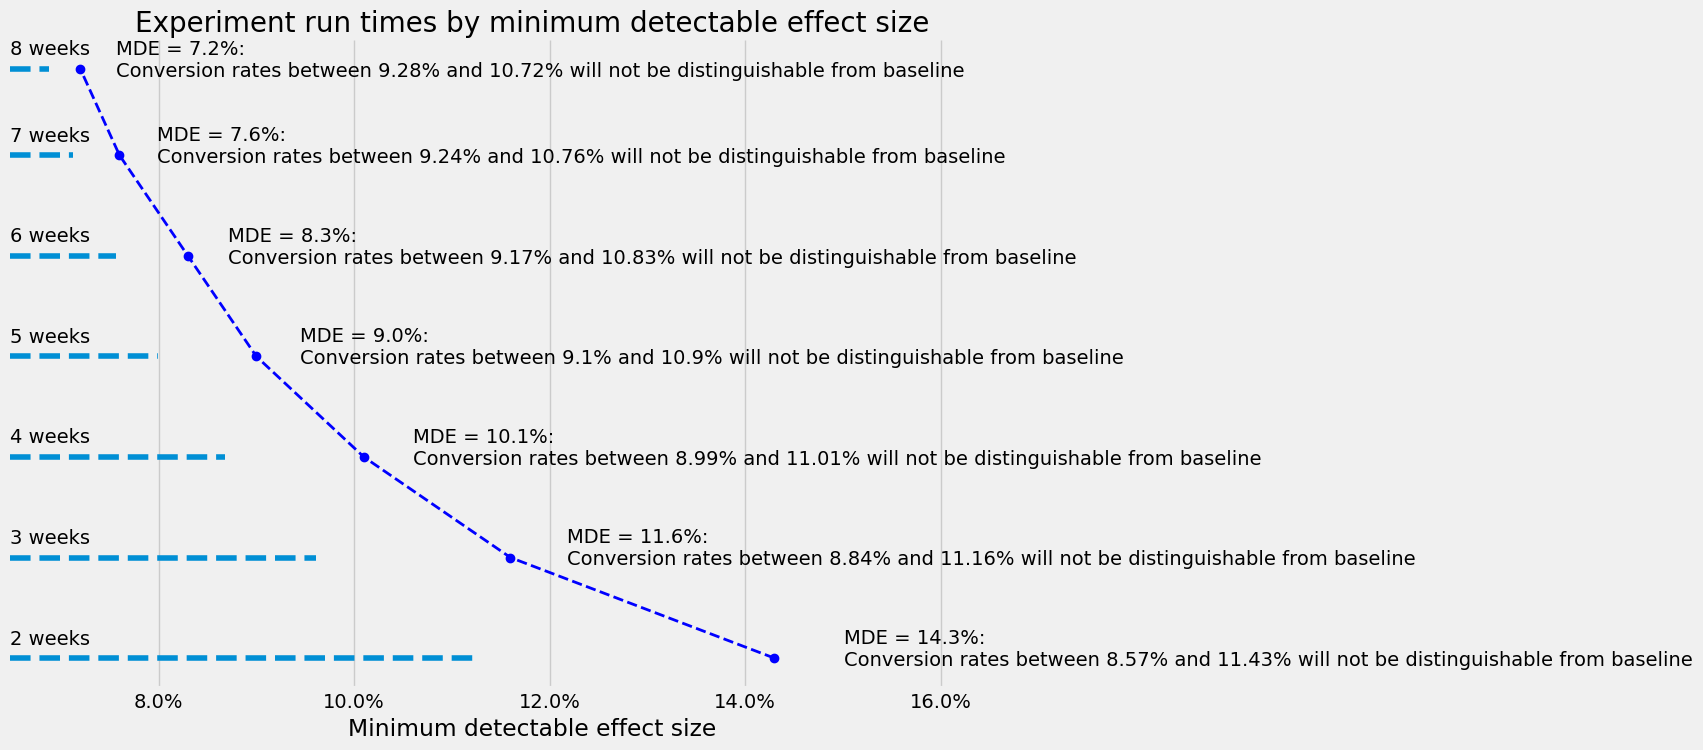

In [109]:
test_experiment.make_mde_plot(df_=df_mde, min_weeks=2, max_weeks=8)

In [118]:
# prop test with fake data
sample_sizes = [138538, 138517, 137562, 138475]
conversions = [130, 162, 169, 164]

not_conversions = [x - y for (x, y) in zip(sample_sizes, conversions)]
contigency = [(x, y) for x, y in zip(conversions, not_conversions)]
T = np.array(contigency)

In [119]:
stats.chi2_contingency(T, correction=True)

Chi2ContingencyResult(statistic=6.244363060071456, pvalue=0.10030814068159973, dof=3, expected_freq=array([[   156.54945289, 138381.45054711],
       [   156.52572266, 138360.47427734],
       [   155.44656224, 137406.55343776],
       [   156.47826221, 138318.52173779]]))

In [120]:
stats.chi2_contingency(T, correction=False)

Chi2ContingencyResult(statistic=6.244363060071456, pvalue=0.10030814068159973, dof=3, expected_freq=array([[   156.54945289, 138381.45054711],
       [   156.52572266, 138360.47427734],
       [   155.44656224, 137406.55343776],
       [   156.47826221, 138318.52173779]]))

In [121]:
p_c_vs_v2 = proportions_ztest(count=[conversions[0], conversions[1]], nobs=[sample_sizes[0], sample_sizes[1]], alternative='two-sided')[1]
p_c_vs_v3 = proportions_ztest(count=[conversions[0], conversions[2]], nobs=[sample_sizes[0], sample_sizes[2]], alternative='two-sided')[1]
p_c_vs_v4 = proportions_ztest(count=[conversions[0], conversions[3]], nobs=[sample_sizes[0], sample_sizes[3]], alternative='two-sided')[1]
p_v2_vs_v3 = proportions_ztest(count=[conversions[1], conversions[2]], nobs=[sample_sizes[1], sample_sizes[2]], alternative='two-sided')[1]
p_v2_vs_v4 = proportions_ztest(count=[conversions[1], conversions[3]], nobs=[sample_sizes[1], sample_sizes[3]], alternative='two-sided')[1]
p_v3_vs_v4 = proportions_ztest(count=[conversions[2], conversions[3]], nobs=[sample_sizes[2], sample_sizes[3]], alternative='two-sided')[1]

In [122]:
multipletests(pvals=[p_c_vs_v2, p_c_vs_v3, p_c_vs_v4, p_v2_vs_v3, p_v2_vs_v4, p_v3_vs_v4], method='bonferroni')


(array([False, False, False, False, False, False]),
 array([0.36480431, 0.12275362, 0.28095308, 1.        , 1.        ,
        1.        ]),
 0.008512444610847103,
 0.008333333333333333)

In [123]:
# None of these are statistically significant 
